# ARIMA(Autoregressive Integrated Moving Average) Model

3 components p, d and q, pdq非负整数:

- AR(p) Autoregression
- I(d) Integrated
- MA(q) Moving Average

整合移动平均自回归模型，是时间序列预测分析方法之一。

用于分析非平稳性non-stationary的时序数据(无法呈现出一个长期趋势并最终趋于一个常数或是一个线性函数).

## 笔记

#### 1. 先判断数据是否是平稳的

什么是非平稳数据？

- no constant mean
- variance is a function of time
- covariance is a function of time

如果判断出数据是非平稳的（看出来或算出来），要先transform it to be stationary to evaluate it and what type of ARIMA terms you will use.

#### 2. 如果数据是非平稳的，先用differencing转化

用第n项数据减去第n-1项，一次一次.shift(1)做直到数据变平稳，但是每做一次每次最前面的那个数据就会被损失掉变NA。

如果是seasonal data，可以difference by a season，比如yearly seasonality可以difference by a time unit of 12就是直接.shift(12)


## Whole Process

The general process for ARIMA models is the following:
* Visualize the time series data
* Testing for stationarity 
* Make the time series data stationary
* Plot the Correlation and AutoCorrelation Charts
* Construct the ARIMA Model
* Use the model to make predictions

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/Python-for-Finance-Repo-master/08-Time-Series-Analysis/monthly-milk-production-pounds-p.csv')
df.head()

Mounted at /content/drive


,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [3]:
df.columns = ['Month', 'Milk in pounds per cow']
df # the last row needs to be deleted

,Month,Milk in pounds per cow
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0
...,...,...
164,1975-09,817.0
165,1975-10,827.0
166,1975-11,797.0
167,1975-12,843.0


In [4]:
# clean and format
# delete the last row
df.drop([len(df) - 1], axis=0, inplace=True)
# format the Month column and set it to be the index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month',inplace=True)
df.head()

,Milk in pounds per cow
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


### 1 Visualize the Time Series Data

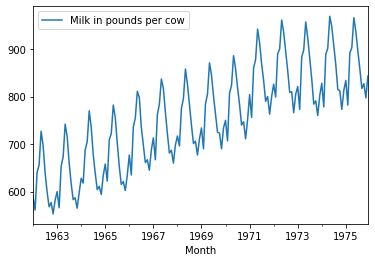

In [5]:
df.plot() 

It appears to be seasonal data and has a trend.

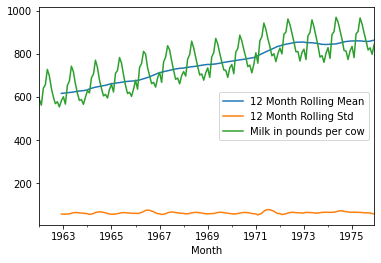

In [6]:
timeseries = df['Milk in pounds per cow']
# 12 month rolling simple average is a reflection of the yearly moving average
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.rolling(12).std().plot(label='12 Month Rolling Std')
timeseries.plot()
plt.legend()

There is some sort of upward trend here and the std deviation is pretty flat.

#### ETS Decomposition
 
ETS decomposition allows us to see the individual parts!

（不记得就去看statsmodel那个notebook

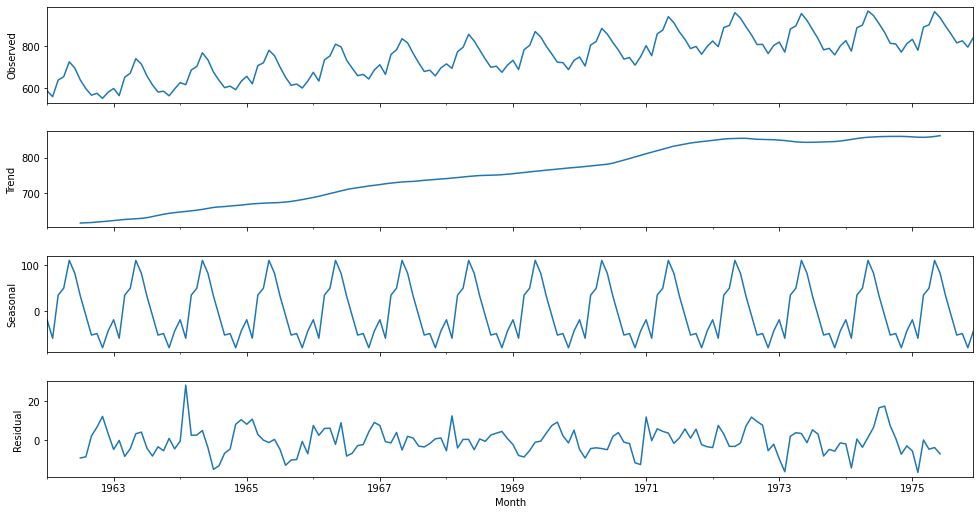

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Milk in pounds per cow'], freq=12)  
# if you wanted to make sure that every period was a yearly period for the season you could set the frequency to be 12 
# fig = plt.figure()  
fig = decomposition.plot()  # 之前如果直接画图会出两个图的bug，如果只想要出一张图就这样写
fig.set_size_inches(15, 8)

We have now realized that our data is seasonal (it is also pretty obvious from the plot itself). This means we need to use Seasonal ARIMA on our model. If our data was not seasonal, it means we could use just ARIMA on it. We will take this into account when differencing our data

**Typically financial stock data won't be seasonal, that won't work well on stock finance data!**

### 2 Testing for Stationarity

Use the Augmented Dickey-Fuller unit root test.

一般的设置都是：

- Null Hypothesis H0: the time series has a unit root, indicating it is non-stationary

- Alternative Hypo: no unit root, stationary

计算p-value:

- A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis.

- A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so you fail to reject the null hypothesis.




In [8]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Milk in pounds per cow'])

In [9]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [10]:
adf_check(timeseries)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.3038115874221299
p-value : 0.6274267086030314
#Lags Used : 13
Number of Observations Used : 154
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


OK 现在知道这数据non-stationary要做difference

### 3 Make the time series data stationary

The first difference of a time series is the series of changes from one period to the next. You can continue second difference, third difference, until the data is stationary.

#### The 1st difference

In [11]:
df['Milk First Difference'] = df['Milk in pounds per cow'] - df['Milk in pounds per cow'].shift(1)

In [13]:
# 重复第二步的验证操作
adf_check(df['Milk First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -3.0549955586531126
p-value : 0.030068004001782136
#Lags Used : 14
Number of Observations Used : 152
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


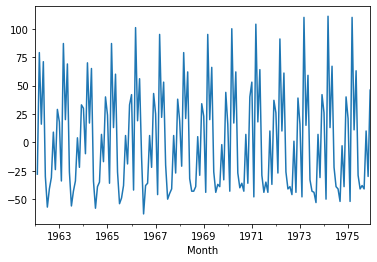

In [15]:
df['Milk First Difference'].plot()

OK 第一次做完已经是stationary了可以不用做第二次了，如果要做第二次就：

df['Milk Second Difference'] = df['Milk First Difference'] - df['Milk First Difference'].shift(1)

#### Seasonal Difference

In [16]:
df['Seasonal Difference'] = df['Milk in pounds per cow'] - df['Milk in pounds per cow'].shift(12)
adf_check(df['Seasonal Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.335419314359398
p-value : 0.1607988052771135
#Lags Used : 12
Number of Observations Used : 143
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


Seasonal Difference by itself was not enough!

#### Seasonal First Difference

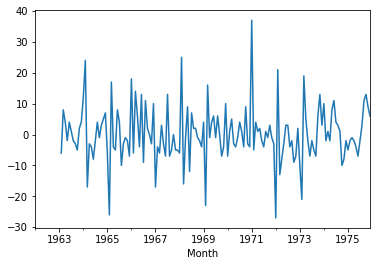

In [17]:
df['Seasonal First Difference'] = df['Milk First Difference'] - df['Milk First Difference'].shift(12)
df['Seasonal First Difference'].plot()

In [18]:
adf_check(df['Seasonal First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.038002274921983
p-value : 1.865423431878848e-05
#Lags Used : 11
Number of Observations Used : 143
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


所以对于这种seasonal的数据，可以直接做difference（可能会需要做很多次），也可以直接尝试seasonal difference，实在不行也可以拿第一次差分后的再做seasonal difference，只要能把数据快速弄成stationary就行。

### 4 Plot the Correlation and AutoCorrelation Charts

An autocorrelation plot (also known as a Correlogram) shows the correlation of the series with itself, lagged by x time units. So the y axis is the correlation and the x axis is the number of time units of lag.

